In [87]:
%matplotlib inline

***Read in WALS Data***

In [88]:
import pandas, numpy as np, scipy.stats, ggplot
wals_data = pandas.read_csv('../0/wals-languages.csv').iloc[:,[0,3,6,7,8,104,106]]
wals_data.columns= ['wals_code','name', 'genus', 'family', 'area', 'adposition','nadj']

***Reorder the categories***

In [89]:
wals_data['adposition'] = wals_data['adposition'].astype('category').cat.reorder_categories([u'5 Other', u'1 OV and Postpositions', 
    u'2 OV and Prepositions', u'3 VO and Postpositions','4 VO and Prepositions'])

# Assess Support Over Languages

In [90]:
def binomTest(df, var, compliantCategories, noncompliantCategories):
    summary = pandas.DataFrame(df[var].value_counts())
    compliant = sum(summary.loc[compliantCategories,0])
    noncompliant = sum(summary.loc[noncompliantCategories,0])
    total = compliant + noncompliant
    return({'propCompliant':float(compliant)/float(total), 'p-value':scipy.stats.binom_test(compliant,total,p=0.5)})        

def propCompliant(df, var, compliantCategories, noncompliantCategories):
    summary = pandas.DataFrame(df[var].value_counts())
    compliant = sum(summary.loc[compliantCategories,0])
    noncompliant = sum(summary.loc[noncompliantCategories,0])
    total = compliant + noncompliant
    return({'propCompliant':float(compliant)/float(total)})        

## Word order vs. Position of Adpositions

In [91]:
wals_data['adposition'].value_counts()

1 OV and Postpositions    472
4 VO and Prepositions     456
5 Other                   158
3 VO and Postpositions     42
2 OV and Prepositions      14
dtype: int64

In [92]:
binomTest(wals_data,'adposition', [u'1 OV and Postpositions',u'4 VO and Prepositions'], [u'3 VO and Postpositions',u'2 OV and Prepositions'])

{'p-value': 1.5048685607049431e-204, 'propCompliant': 0.943089430894309}

## Word order vs. Position of Adjectives

In [93]:
wals_data['nadj'] = wals_data['nadj'].astype('category').cat.reorder_categories([ u'1 OV and AdjN',u'2 OV and NAdj',u'3 VO and AdjN',u'4 VO and NAdj',  u'5 Other'])              

In [94]:
wals_data['nadj'].value_counts()

4 VO and NAdj    456
2 OV and NAdj    332
1 OV and AdjN    216
5 Other          198
3 VO and AdjN    114
dtype: int64

In [95]:
binomTest(wals_data,'nadj', [u'1 OV and AdjN',u'4 VO and NAdj'], [u'2 OV and NAdj',u'3 VO and AdjN'])

{'p-value': 1.4610894083389258e-11, 'propCompliant': 0.6010733452593918}

# Assess Support over Genera

In [96]:
# define some wrappers to hard-code the success and failure categories
def prop_nadj(df):
    return(propCompliant(df,'nadj', [u'1 OV and AdjN',u'4 VO and NAdj'], [u'2 OV and NAdj',u'3 VO and AdjN']))

def prop_adposition(df):
    return(propCompliant(df,'adposition', [u'1 OV and Postpositions',u'4 VO and Prepositions'], [u'3 VO and Postpositions',u'2 OV and Prepositions']))
        
    
def stratified_sample(varOfInterest, stratVar, df, numSamples, fn):    
    df = df.dropna(subset=[varOfInterest])
    stratified = df.groupby(wals_data[stratVar])
    
    indicesPerStrata = stratified.apply(lambda obj: obj.index.astype('int')) #indices that are in each strata
        
    results = []
    for i in range(numSamples):       
        sample_indices = np.vstack([np.random.choice(x, size=1) for x in indicesPerStrata]).flatten() # choose randomly from each group of indices in indicesPerStrata
        rd = fn(df.ix[sample_indices,:])
        if(rd):
            results.append(rd)
    return(pandas.DataFrame(results)) 

## Word order vs. Position of Adpositions

In [97]:
bootstrap_adposition_genus = stratified_sample(u'adposition',u'genus',wals_data, 5000,prop_adposition)

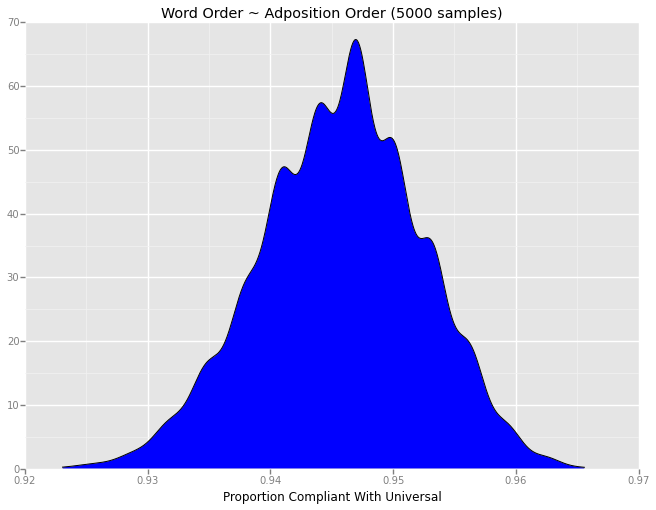

<ggplot: (8761922926969)>

In [98]:
ggplot.ggplot(bootstrap_adposition_genus, ggplot.aes(x='propCompliant')) + ggplot.stat_density(fill='blue') +\
ggplot.xlab('Proportion Compliant With Universal')  + ggplot.ggtitle('Word Order ~ Adposition Order (5000 samples)') 

## Word order vs. Position of Adjectives

In [99]:
bootstrap_nadj_genus = stratified_sample(u'nadj',u'genus',wals_data, 5000,prop_nadj)

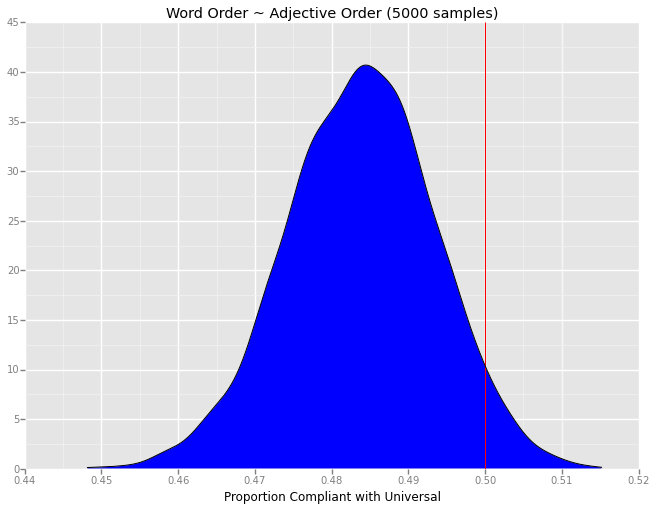

<ggplot: (8761922714829)>

In [100]:
ggplot.ggplot(bootstrap_nadj_genus, ggplot.aes(x='propCompliant')) + ggplot.stat_density(fill='blue') + ggplot.xlab('Proportion Compliant with Universal') +\
ggplot.ggtitle('Word Order ~ Adjective Order (5000 samples)') + ggplot.geom_vline(xintercept=[.5], colour='red')